# Scale Detection
Train a model to detect the scale of an image relative to the scale of the training dataset for a model.

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Set up some global constants and shared filepaths

SEED = 123  # random seed for splitting data into train/test

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))

MODEL_NAME = 'ScaleDetectionModel'

MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME + '.h5')

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Load the training data

Download data for nuclear, brightfield and fluorescent cytoplasm from `deepcell.datasets` and combine the data into a single training dataset.

In [3]:
# First, download the data from deepcell.datasets
import deepcell.datasets

# nuclear data (label type 0)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(seed=SEED)
nuclear_train = {'X': X_train, 'y': y_train}
nuclear_test = {'X': X_test, 'y': y_test}

6370107392/6370099814 [==============================] - 276s 0us/step


In [4]:
# brightfield phase data (label type 1)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.phase.HeLa_S3.load_data(seed=SEED)
brightfield_train = {'X': X_train, 'y': y_train}
brightfield_test = {'X': X_test, 'y': y_test}

4328529920/4328522342 [==============================] - 183s 0us/step


In [5]:
# flourescent cytoplasm data (label type 2)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.cytoplasm.hela_s3.load_data(seed=SEED)
flourescent_train = {'X': X_train, 'y': y_train}
flourescent_test = {'X': X_test, 'y': y_test}

4328529920/4328522342 [==============================] - 181s 0us/step


### Flatten All Datasets into 2D and Combine

In [6]:
# Reshape each dataset to conform to the minimum size of 216
from deepcell.utils.data_utils import reshape_matrix

RESHAPE_SIZE = 216

all_train = [nuclear_train, brightfield_train, flourescent_train]
all_test = [nuclear_test, brightfield_test, flourescent_test]

for train, test in zip(all_train, all_test):
    train['X'], train['y'] = reshape_matrix(train['X'], train['y'], RESHAPE_SIZE)
    test['X'], test['y'] = reshape_matrix(test['X'], test['y'], RESHAPE_SIZE)

Reshaped feature data from (5760, 216, 256, 1) to (5760, 216, 216, 1)
Reshaped training data from (5760, 216, 256, 1) to (5760, 216, 216, 1)
Reshaped feature data from (1440, 216, 256, 1) to (1440, 216, 216, 1)
Reshaped training data from (1440, 216, 256, 1) to (1440, 216, 216, 1)
Reshaped feature data from (1651, 512, 512, 1) to (14859, 216, 216, 1)
Reshaped training data from (1651, 512, 512, 1) to (14859, 216, 216, 1)
Reshaped feature data from (413, 512, 512, 1) to (3717, 216, 216, 1)
Reshaped training data from (413, 512, 512, 1) to (3717, 216, 216, 1)
Reshaped feature data from (1651, 512, 512, 1) to (14859, 216, 216, 1)
Reshaped training data from (1651, 512, 512, 1) to (14859, 216, 216, 1)
Reshaped feature data from (413, 512, 512, 1) to (3717, 216, 216, 1)
Reshaped training data from (413, 512, 512, 1) to (3717, 216, 216, 1)


In [7]:
# Stack up our data as train and test
X_train = np.vstack([
    nuclear_train['X'],
    brightfield_train['X'],
    flourescent_train['X']
])

y_train = np.vstack([
    nuclear_train['y'],
    brightfield_train['y'],
    flourescent_train['y']
])

X_test = np.vstack([
    nuclear_test['X'],
    brightfield_test['X'],
    flourescent_test['X']
])

y_test = np.vstack([
    nuclear_test['y'],
    brightfield_test['y'],
    flourescent_test['y']
])

## Create the Scale Detection Model

We are using the ScaleDetectionModel from `deepcell.applications`

In [9]:
from deepcell.applications import ScaleDetectionModel

# set use_pretrained_weights to False to retrain from scratch
model = ScaleDetectionModel(
    backbone='mobilenetv2',
    input_shape=X_train.shape[1:],
    use_pretrained_weights=False)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 216, 1)  0                                            
__________________________________________________________________________________________________
image_normalization2d (ImageNor (None, 216, 216, 1)  3721        input_1[0][0]                    
__________________________________________________________________________________________________
tensor_product (TensorProduct)  (None, 216, 216, 3)  6           image_normalization2d[0][0]      
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 217, 217, 3)  0           tensor_product[0][0]             
__________________________________________________________________________________________________
Conv1 (Con

In [10]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20
batch_size = 64
lr = 1e-3

optimizer = Adam(lr=lr, clipnorm=.001)
lr_sched = rate_scheduler(lr=lr, decay=0.9)

model.compile(optimizer, loss='mse', metrics=['mae', 'mape'])

## Train the Model

Create the ImageDataGenerators and pass them to `model.fit_generator`.

In [11]:
from deepcell.image_generators import ScaleDataGenerator

# Create the image data generator for training

generator = ScaleDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=(0.5, 2)
)

In [12]:
from tensorflow.keras import callbacks

model.fit_generator(
    generator.flow({'X': X_train, 'y': y_train}, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=generator.flow({'X': X_test, 'y': y_test}, batch_size=batch_size),
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, MODEL_NAME + '.h5'),
            verbose=1,
            monitor='val_loss',
            save_best_only=True)
    ]
)

Epoch 1/20
553/554 [============================>.] - ETA: 0s - loss: 0.0654 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 14.1563
Epoch 00001: val_loss improved from inf to 0.26519, saving model to /data/models/ScaleDetectionModel.h5
554/554 [==============================] - 213s 384ms/step - loss: 0.0653 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 14.1377 - val_loss: 0.2652 - val_mean_absolute_error: 0.4264 - val_mean_absolute_percentage_error: 33.2867
Epoch 2/20
553/554 [============================>.] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 4.6673
Epoch 00002: val_loss improved from 0.26519 to 0.21432, saving model to /data/models/ScaleDetectionModel.h5
554/554 [==============================] - 175s 316ms/step - loss: 0.0047 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 4.6642 - val_loss: 0.2143 - val_mean_absolute_error: 0.3937 - val_mean_absolute_percentage_error: 43.6104
Ep

553/554 [============================>.] - ETA: 0s - loss: 9.2559e-05 - mean_absolute_error: 0.0073 - mean_absolute_percentage_error: 0.7014
Epoch 00018: val_loss did not improve from 0.00021
554/554 [==============================] - 174s 315ms/step - loss: 9.2533e-05 - mean_absolute_error: 0.0073 - mean_absolute_percentage_error: 0.7012 - val_loss: 5.4788e-04 - val_mean_absolute_error: 0.0212 - val_mean_absolute_percentage_error: 1.7415
Epoch 19/20
553/554 [============================>.] - ETA: 0s - loss: 8.6865e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 0.6812
Epoch 00019: val_loss improved from 0.00021 to 0.00011, saving model to /data/models/ScaleDetectionModel.h5
554/554 [==============================] - 175s 317ms/step - loss: 8.6938e-05 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 0.6816 - val_loss: 1.1203e-04 - val_mean_absolute_error: 0.0079 - val_mean_absolute_percentage_error: 0.8320
Epoch 20/20
553/554 [========================

## Run the model on test data

Run the model on validation data and visualize the performance.

In [13]:
model.load_weights(os.path.join(MODEL_DIR, MODEL_NAME + '.h5'))

test_data = generator.flow({'X': X_test, 'y': y_test}, batch_size=1)

true, pred = [], []
for i in range(1000):
    if i % 100 == 0:
        print(".", end="")

    X, y = test_data.next()
    true.append(y)
    pred.append(model.predict(X))
    
true = np.array(true)
pred = np.array(pred)

..........

Text(0, 0.5, 'Error')

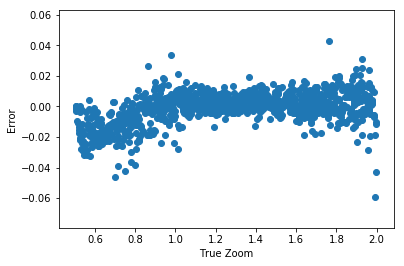

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(true, pred - true)
ax.set_xlabel('True Zoom')
ax.set_ylabel('Error')